In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.io as sio
import glob


In [114]:
def load_and_process_data(directory_path, part_of_file_name):
    # get latest file from data folder that includes part_of_file_name in its name
    fileIs = sorted((f for f in glob.glob(f"{directory_path}/*") if part_of_file_name in f), key=os.path.getctime)[-1]

    # load the .mat file
    mat_contents = sio.loadmat(fileIs)
    print(f"Loaded {fileIs.split('_')[2]}")
    # extract the necessary data
    sigma, eyeResp, target = mat_contents['sigma'], mat_contents['eyeX'], mat_contents['blob_x']
    mouseResp = mat_contents['mouse_x'] if fileIs.split('_')[2] == "both" else None
    if mouseResp is not None:
        mouseResp = mouseResp - np.mean(mouseResp, axis=1, keepdims=True)
    eyeResp = eyeResp - np.mean(eyeResp, axis=1, keepdims=True)
    target = target - np.mean(target, axis=1, keepdims=True)
   
    # calculate the number of trials
    nTrial = len(sigma.flatten())
    nSigma = (nTrial - 1) // 5 + 1
    nTrialPerSigma = nTrial // nSigma
    blob_widths = np.unique(sigma.flatten())

    sigma = sigma.flatten()
    return fileIs,sigma, eyeResp, target, mouseResp, nTrial, nSigma, nTrialPerSigma, blob_widths

fileIs,sigma, eyeResp, target, mouseResp = load_and_process_data("data_eye", "p8_eye_continous_psych_2024")[:5]
blob_widths = np.unique(sigma.flatten())
# calculate the number of trials
nTrial = len(sigma.flatten())
nSigma = (nTrial - 1) // 5 + 1
nTrialPerSigma = nTrial // nSigma
respMode='eyeResp'
print(nTrial, nSigma, nTrialPerSigma, blob_widths)
#mouseResp.shape

Loaded eye
15 3 5 [11 17 25]


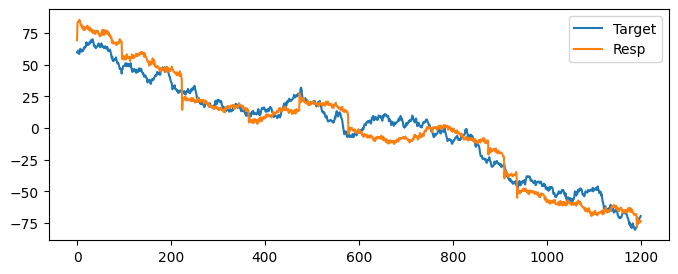

In [115]:
trialNum=2
plt.figure(figsize=(8,3))
plt.plot(target[trialNum,:])
#plt.plot(mouseResp[trialNum,:])
plt.plot(eyeResp[trialNum,:])
plt.legend(['Target','Resp'])
plt.show()

## - Smooth data if needed

In [116]:
from scipy.ndimage import gaussian_filter1d

def smooth_data(data_to_smooth, window_size=10):
    # Create a moving average filter
    filter = np.ones(window_size) / window_size
    # Apply the filter to the response data using list comprehension
    smoothed_response = [np.convolve(trial, filter, mode='same') for trial in data_to_smooth]
    return np.squeeze(smoothed_response)
eyeResp = smooth_data(eyeResp)
#target = smooth_data(target)

### -Create a dictionary for response and target

In [117]:
def create_sorted_trial_dict(nTrial, target, eyeResp, sigma, fileIs, mouseResp=None):
    # create key-value pairs for the dictionary of 30 trials
    trial_dict = {}
    for i in range(nTrial):
        trial_dict[i] = {'target': target[i,60:], 'eyeResp': eyeResp[i,60:], 'sigma': sigma[i]} #my data
        if fileIs.split('_')[2] == "both":
            trial_dict[i]['mouseResp'] = mouseResp[i,60:]

    # sort the dictionary by sigma
    trialDictSorted = sorted(((k, v) for k, v in trial_dict.items()), key=lambda x: x[1]['sigma']) # x[1]['sigma'] gives the value of sigma for each trial and la
    tmp_trial = trialDictSorted[0][1]

    return trialDictSorted, tmp_trial

trialDictSorted, tmp_trial = create_sorted_trial_dict(nTrial, target, eyeResp, sigma, fileIs, mouseResp)


## - Avarage CCG across different blob widths for single participant

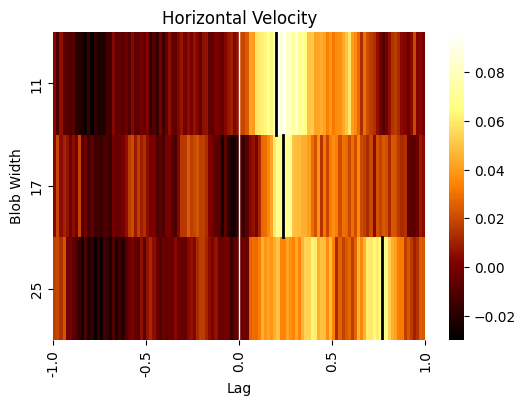

<module 'matplotlib.pyplot' from 'C:\\Users\\omeru\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\pyplot.py'>

In [118]:
def calculate_ccg(X, Y):
    X = np.diff(X)
    Y = np.diff(Y)
    X = (X - np.mean(X)) / np.std(X) # take the z-score of the data
    Y = (Y - np.mean(Y)) / np.std(Y) # take the z-score of the data
    #return np.correlate(X, Y, 'full')
    ccg = np.correlate(X, Y, 'full')
    return ccg / (len(X) * np.std(X) * np.std(Y))

def calculate_ccgs_for_blob_width(trialDictSorted, blob_width, nTrialPerSigma):
    ccg_single_blobs = []
    for i in range(nTrialPerSigma):
        tmp_trial = trialDictSorted[i + blob_width * nTrialPerSigma][1]
        X = tmp_trial[respMode]
        Y = tmp_trial['target']
        ccg_single_trial = calculate_ccg(X, Y)
        ccg_single_blobs.append(ccg_single_trial)
    return ccg_single_blobs

def calculate_ccgs_for_all_blob_widths(trialDictSorted, blob_widths, nTrialPerSigma):
    ccg_single_blob = []
    ccg_blob_mean = []
    for blob_width in range(len(blob_widths)):
        ccg_single_blobs = calculate_ccgs_for_blob_width(trialDictSorted, blob_width, nTrialPerSigma)
        ccg_single_blob.append(ccg_single_blobs)
        ccg_blob_mean.append(np.mean(ccg_single_blob[blob_width], axis=0))
    return ccg_blob_mean, ccg_single_blob

def trim_ccgs(ccgs, len_trial, lag_range):
    ccgs = np.array(ccgs)
    return ccgs[:, len_trial - lag_range : len_trial + lag_range]

def plot_heatmap(ccg_blob_mean_trimmed, blob_widths, lag_range):
    plt.figure(figsize=(6, 4))
    sns.heatmap(ccg_blob_mean_trimmed, cmap='afmhot', yticklabels=blob_widths)
    x = np.linspace(0, frameRate * lag_time * 2, 5)
    labels = np.linspace(-lag_time, lag_time, len(x))
    plt.xticks(x, labels, rotation='vertical')
    plt.title('Horizontal Velocity')
    plt.xlabel('Lag')
    plt.ylabel('Blob Width')
    plt.axvline(x=lag_range, color='white', linestyle='-', linewidth=1)
    return plt

def plot_heatmap_eachTrial(ccg_single_trials_trimmed, blob_widths, lag_range):
    plt.figure(figsize=(6, 4))
    sns.heatmap(ccg_single_trials_trimmed, cmap='afmhot')
    x = np.linspace(0, frameRate * lag_time * 2, 5)
    labels = np.linspace(-lag_time, lag_time, len(x))
    plt.xticks(x, labels, rotation='vertical')
    ## set y axis ticks based on blob widths so that each 5 rows are for the same blob width
    yticks=np.linspace(0, len(ccg_single_trials_trimmed), len(blob_widths))
    yticklabels=blob_widths
    plt.yticks(yticks, yticklabels)
    plt.title('Horizontal Velocity')
    plt.xlabel('Lag')
    plt.ylabel('Blob Width')
    return plt

def find_and_plot_peak_indices(ccg_blob_mean_trimmed, blob_widths):
    timePoints = ccg_blob_mean_trimmed.shape[1]
    peak_indices = np.argmax(ccg_blob_mean_trimmed, axis=1)
    peak_indices = np.where(peak_indices > timePoints // 2, peak_indices, -1)
    for i, peak_index in enumerate(peak_indices):
        plt.axvline(x=peak_index, color='black', linestyle='-', linewidth=2, ymin=1 - (i / len(blob_widths)), ymax=1 - ((i + 1) / len(blob_widths)))
    plt.show()


def plot_peaksAndHeatmap(ccg_blob_mean_trimmed, blob_widths):
    plt = plot_heatmap(ccg_blob_mean_trimmed, blob_widths, lag_range)
    find_and_plot_peak_indices(ccg_blob_mean_trimmed, blob_widths)
    return plt

# Now you can use these functions in your main code
blob_widths = np.unique(sigma)
nTrialPerSigma = 5 # You need to define this
frameRate = 60
lag_time = 1
lag_range = int(lag_time * frameRate)
len_trial = len(trialDictSorted[0][1]['target'])

def process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range):
    ccg_blob_mean, ccg_single_blob = calculate_ccgs_for_all_blob_widths(trialDictSorted, blob_widths, nTrialPerSigma)
    ccg_blob_mean = np.array(ccg_blob_mean)
    ccg_blob_mean_trimmed = trim_ccgs(ccg_blob_mean, len_trial, lag_range)
    ccg_single_blob_trimmed = trim_ccgs(ccg_single_blob, len_trial, lag_range)
    ccg_single_blob = np.array(ccg_single_blob)
    ccg_single_trials = ccg_single_blob.reshape(ccg_single_blob.shape[0]*ccg_single_blob.shape[1], ccg_single_blob.shape[2])
    ccg_single_trials_trimmed = ccg_single_trials[:, len_trial - lag_range: len_trial + lag_range]
    return ccg_blob_mean_trimmed, ccg_single_trials_trimmed,ccg_blob_mean, ccg_single_blob,ccg_single_trials

ccg_blob_mean_trimmed, ccg_single_trials_trimmed, ccg_blob_mean, ccg_single_blob,ccg_single_trials= process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range)

# plt = plot_heatmap(ccg_blob_mean_trimmed, blob_widths, lag_range)
# find_and_plot_peak_indices(ccg_blob_mean_trimmed, blob_widths)

plot_peaksAndHeatmap(ccg_blob_mean_trimmed, blob_widths)



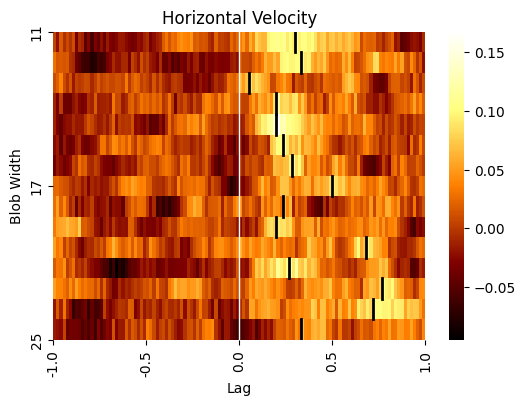

In [119]:
def find_and_plot_peak_indices_eachTrial(ccg_single_trials_trimmed, nTrial):
    timePoints = ccg_single_trials_trimmed.shape[1]
    peak_indices = np.argmax(ccg_single_trials_trimmed, axis=1)
    peak_indices = np.where(peak_indices > timePoints // 2, peak_indices, -1)
    for i, peak_index in enumerate(peak_indices):
        plt.axvline(x=peak_index, color='black', linestyle='-', linewidth=2, ymin=1-(i+1)/nTrial, ymax=1-(i)/nTrial)

def plot_ccg_heatmap_with_peaks(ccg_single_trials_trimmed, blob_widths, frameRate, lag_time, nTrial):
    plot_heatmap_eachTrial(ccg_single_trials_trimmed, blob_widths, lag_time)
    find_and_plot_peak_indices_eachTrial(ccg_single_trials_trimmed, nTrial)
    plt.axvline(x=lag_range,color='white',linestyle='-',linewidth=1)
    plt.show()

# Now you can use this function in your main code
plot_ccg_heatmap_with_peaks(ccg_single_trials_trimmed, blob_widths, frameRate, lag_time, nTrial)


In [120]:
ccg_blob_mean_trimmed, ccg_single_trials_trimmed, ccg_blob_mean, ccg_single_blob,ccg_single_trials= process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range)
#plot_peaksAndHeatmap(ccg_blob_mean_trimmed, blob_widths)
#plot_ccg_heatmap_with_peaks(ccg_single_trials_trimmed, blob_widths, frameRate, lag_time, nTrial)

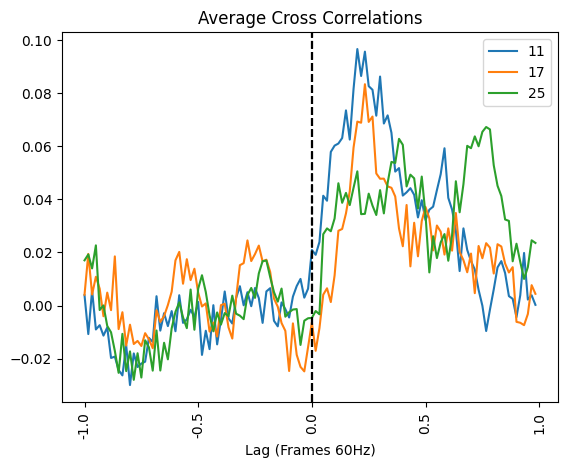

In [122]:
def plot_ccg(ccg, len_trial, steps, bw):
    plt.plot(ccg[len_trial-steps:len_trial+steps], label=bw)
    plt.legend()

def set_x_axis_ticks(time_lag, frameRate):
    x = np.linspace(0, frameRate * time_lag * 2, 5)
    labels = np.linspace(-time_lag, time_lag, len(x))
    plt.xticks(x, labels, rotation='vertical')

def plot_vertical_line(time_lag, frameRate):
    plt.axvline(time_lag * frameRate, color='black', linestyle='--')

def set_plot_title_and_labels():
    plt.title('Average Cross Correlations')
    plt.xlabel('Lag (Frames 60Hz)')

def plot_mean_ccgs(blob_widths, trialDictSorted, ccg_blob_mean):
    len_trial = len(trialDictSorted[0][1]['target'])
    frameRate = 60
    time_lag = 1  # seconds
    steps = int(frameRate * time_lag)

    for i, bw in enumerate(blob_widths):
        ccg = ccg_blob_mean[i]
        plot_ccg(ccg, len_trial, steps, bw)
        set_x_axis_ticks(time_lag, frameRate)
        plot_vertical_line(time_lag, frameRate)
        set_plot_title_and_labels()
    plt.show()

plot_mean_ccgs(blob_widths, trialDictSorted, ccg_blob_mean)

In [123]:
def single_ccg_taker(sigma=11,lag=1):
    frameRate=60
    steps=int(frameRate*lag)
    blob_ind=sigma_dict[sigma]
    ccg= ccg_single_blob[blob_ind][0]
    return ccg

def within_blob_ccgs(sigma=11,lag=1):
    frameRate=60
    steps=int(frameRate*lag)
    blob_ind=sigma_dict[sigma]
    ccg= ccg_single_blob[blob_ind,:,:]
    ccgs_flat=ccg.flatten()
    return ccgs_flat

def single_trial_selector(sigma=11):
    blob_ind=sigma_dict[sigma]
    trial=trialDictSorted[blob_ind][1]
    return trial
def single_blob_selector(sigma=11):
    blob_ind=sigma_dict[sigma]
    blob=trialDictSorted[blob_ind:blob_ind+nTrialPerSigma]
    return blob

C:\Users\omeru\AppData\Local\Temp\ipykernel_10716\560769263.py:16: RuntimeWarning: divide by zero encountered in log
  return alpha * np.exp(-(np.log(x) - beta) ** 2 / (2 * sigma ** 2)) /( (x * sigma * np.sqrt(2 * np.pi))+1e-100)
C:\Users\omeru\AppData\Local\Temp\ipykernel_10716\560769263.py:80: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=30.0)


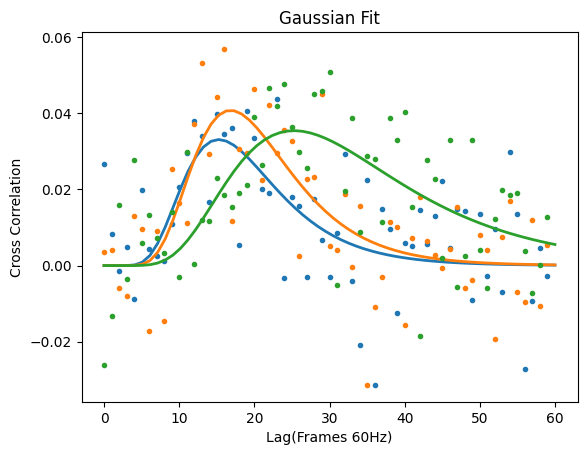

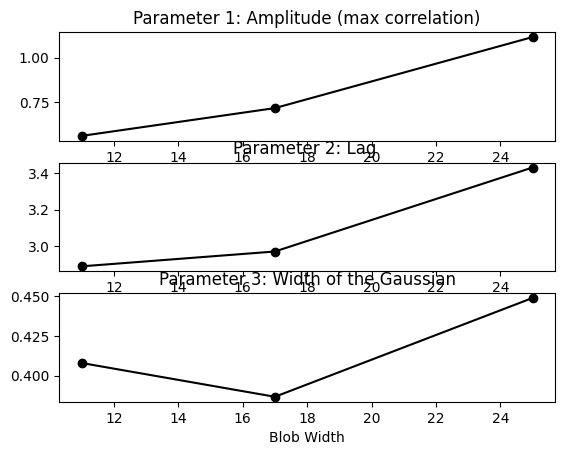

In [158]:
frameRate=60
time_lag=1 # seconds
steps=int(frameRate*time_lag)
from scipy.optimize import curve_fit
import math

blob_ind=2
ccg=ccg_blob_mean[blob_ind]
mid_point = len(ccg) // 2
ydata=ccg[mid_point:mid_point+steps]
xdata= np.linspace(0, len(ydata), len(ydata))

def gaussian(x, alpha, beta, sigma):
    return alpha * np.exp(-(x - beta) ** 2 / (2 * (sigma ** 2)))
def gaussian(x, alpha, beta, sigma):
    return alpha * np.exp(-(np.log(x) - beta) ** 2 / (2 * sigma ** 2)) /( (x * sigma * np.sqrt(2 * np.pi))+1e-100)

def plot_data_and_fit(xdata, ydata, popt,color,alpha,lw=2):
    #plt.plot(xdata, ydata, 'b+:', label='data')
    yFit = gaussian(xdata, *popt)
    plt.plot(xdata, yFit,color=color,alpha=alpha,lw=lw)
    #plt.legend()
    plt.title('Gaussian Fit')
    plt.xlabel('Lag(Frames 60Hz)')
    plt.ylabel('Cross Correlation')

def plot_ccg_avg(ccg, steps, bw, color,alpha):
    mid_point = len(ccg) // 2
    ydata = ccg[mid_point:mid_point+steps]
    xdata = np.linspace(0, len(ydata), len(ydata))
    plt.plot(ccg[mid_point:mid_point+steps],'o', label=bw, markersize=3, color=color, alpha=alpha)
    #plt.legend()
    plt.title('Avarage Cross Correlations')

def fit_gaussian(xdata, ydata):
    sigma_guess= np.std(ydata)
    better_sigma_guess=np.sqrt(np.abs(np.sum((xdata-np.mean(xdata))**2*ydata)/np.sum(ydata)))
    initial_guesses = [np.max(ydata), np.argmax(ydata), better_sigma_guess]
    popt, pcov = curve_fit(gaussian, xdata, ydata, p0=initial_guesses, maxfev=10000)
    return popt, pcov

def plot_subplots(blob_widths, data, axs,alpha=0.5,color='blue'):
    popt_list,popt_covs=process_ccg_data(blob_widths, data, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots, alpha=1,lw=2, shouldPlot=False)
    axs[0].plot(blob_widths, [popt[0] for popt in popt_list],  'o-',alpha=alpha,color=color)
    axs[0].set_title('Parameter 1: Amplitude (max correlation)')
    axs[0].set_xlabel('Blob Width')

    axs[1].plot(blob_widths, [popt[1] for popt in popt_list], 'o-',alpha=alpha,color=color)
    axs[1].set_title('Parameter 2: Lag ')
    axs[1].set_xlabel('Blob Width')

    axs[2].plot(blob_widths, [popt[2] for popt in popt_list], 'o-',alpha=alpha,color=color)
    axs[2].set_title('Parameter 3: Width of the Gaussian')
    axs[2].set_xlabel('Blob Width')

def process_ccg_data(blob_widths, ccg_blob_mean, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots, alpha=0.5,lw=2, shouldPlot=True):
    popt_list = []
    pcov_list = []
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]#, "#d62728", "#9467bd", "#8c564b"]

    for i, bw in enumerate(blob_widths): 
        ccg = ccg_blob_mean[i]
        mid_point = len(ccg) // 2
        ydata = ccg[mid_point:mid_point+steps]
        xdata = np.linspace(0, len(ydata), len(ydata))
        popt, pcov = fit_gaussian(xdata, ydata)
        if shouldPlot:
            plot_ccg_avg(ccg, steps, bw, colors[i],alpha=alpha)
            plot_data_and_fit(xdata, ydata, popt,color=colors[i],alpha=alpha,lw=lw)
        else:
            pass
        popt_list.append(popt)
        pcov_list.append(pcov)
    return popt_list, pcov_list


process_ccg_data(blob_widths, ccg_blob_mean, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots, alpha=1,lw=2)

fig, axs = plt.subplots(3, 1)
fig.tight_layout(pad=30.0)

plot_subplots(blob_widths, ccg_blob_mean, axs,alpha=1,color='black')


In [154]:
import matplotlib.cm as cm
import numpy as np
# Get the 'viridis' colormap
cmap = cm.get_cmap('rainbow')
# Generate 10 evenly spaced values between 0 and 1
values = np.linspace(0, 1, 10)
# Get 10 colors from the colormap
colors = [cmap(value) for value in values]
colors = ['#000000', '#800000', '#008000', '#000080', '#808000', '#800080', '#008080', '#606060', '#804000', '#408080']

C:\Users\omeru\AppData\Local\Temp\ipykernel_10716\2822273860.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')


Loaded both
[[-2.35579828e-04  6.34717973e-05 -7.80003968e-04 ... -2.68189044e-04
   1.57107835e-04  2.01994478e-04]
 [-1.74041117e-04 -2.34712235e-04  4.24557133e-04 ... -8.92752837e-07
  -4.87962122e-05 -3.24618544e-04]
 [ 3.73975606e-04  1.49877929e-04  5.06239785e-04 ... -1.67972835e-04
  -5.45835073e-05 -3.87296798e-05]]


C:\Users\omeru\AppData\Local\Temp\ipykernel_10716\862936047.py:16: RuntimeWarning: divide by zero encountered in log
  return alpha * np.exp(-(np.log(x) - beta) ** 2 / (2 * sigma ** 2)) /( (x * sigma * np.sqrt(2 * np.pi))+1e-10)


([array([0.3004771 , 2.73302223, 0.29097249]),
  array([0.77106033, 3.11960442, 0.48871267]),
  array([0.47034038, 3.34816677, 0.45704855])],
 [array([[0.00452777, 0.00164349, 0.00288244],
         [0.00164349, 0.00580947, 0.00155856],
         [0.00288244, 0.00155856, 0.00535593]]),
  array([[0.02016232, 0.00782341, 0.00845384],
         [0.00782341, 0.01151645, 0.00479198],
         [0.00845384, 0.00479198, 0.00942631]]),
  array([[0.01410363, 0.00862367, 0.00968921],
         [0.00862367, 0.01892876, 0.00848168],
         [0.00968921, 0.00848168, 0.01611827]])])

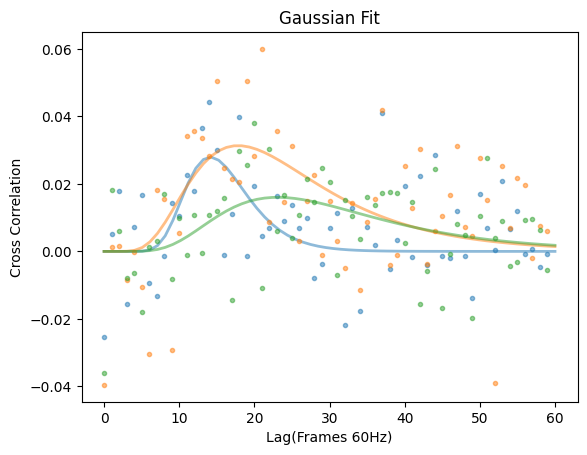

In [155]:
from scipy.optimize import curve_fit
import math
frameRate=60
time_lag=1 # seconds
steps=int(frameRate*time_lag)
numP=5
#respMode='mouseResp'
fileIs,sigma, eyeResp, target, mouseResp = load_and_process_data("data_both", 'p'+str(numP))[:5]
trialDictSorted, tmp_trial = create_sorted_trial_dict(nTrial, target, eyeResp, sigma, fileIs, mouseResp)
ccg_blob_mean_trimmed, ccg_single_trials_trimmed, ccg_blob_mean, ccg_single_blob,ccg_single_trials= process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range)
#plot_peaksAndHeatmap(ccg_blob_mean_trimmed, blob_widths)
#plot_ccg_heatmap_with_peaks(ccg_single_trials_trimmed, blob_widths, frameRate, lag_time, nTrial)
#plot_mean_ccgs(blob_widths, trialDictSorted, ccg_blob_mean)
ccg=[]
xdata=[]
ydata=[]
mid_point = 0
print(ccg_blob_mean)

process_ccg_data(blob_widths, ccg_blob_mean, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots)



In [156]:
file_list = os.listdir("data_both")
from scipy.optimize import curve_fit
import math
frameRate=60
time_lag=1 # seconds
steps=int(frameRate*time_lag)
file_list[0]

'p0_both_185776_continous_psych_2024-03-11_11h48.21.062.mat'

Loaded both
Loaded both


C:\Users\omeru\AppData\Local\Temp\ipykernel_10716\862936047.py:16: RuntimeWarning: divide by zero encountered in log
  return alpha * np.exp(-(np.log(x) - beta) ** 2 / (2 * sigma ** 2)) /( (x * sigma * np.sqrt(2 * np.pi))+1e-10)


Loaded both
Loaded both
Loaded both
Loaded both
Loaded both
Loaded both
Loaded both
Loaded both


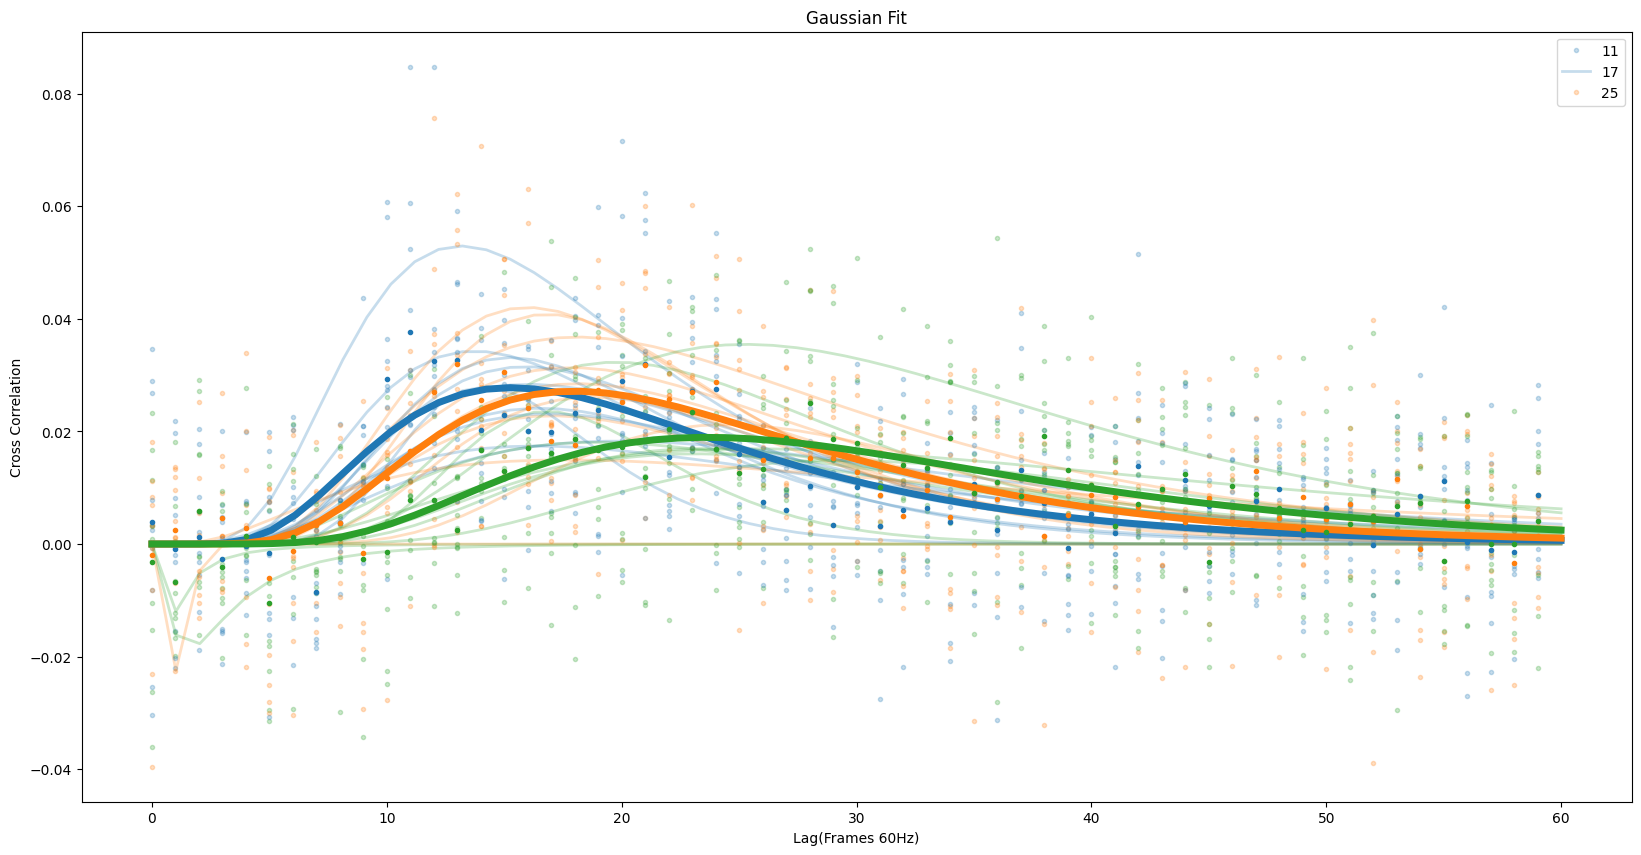

C:\Users\omeru\AppData\Local\Temp\ipykernel_10716\161409306.py:60: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=30.0)


Loaded both
Loaded both
Loaded both
Loaded both
Loaded both
Loaded both
Loaded both
Loaded both
Loaded both
Loaded both


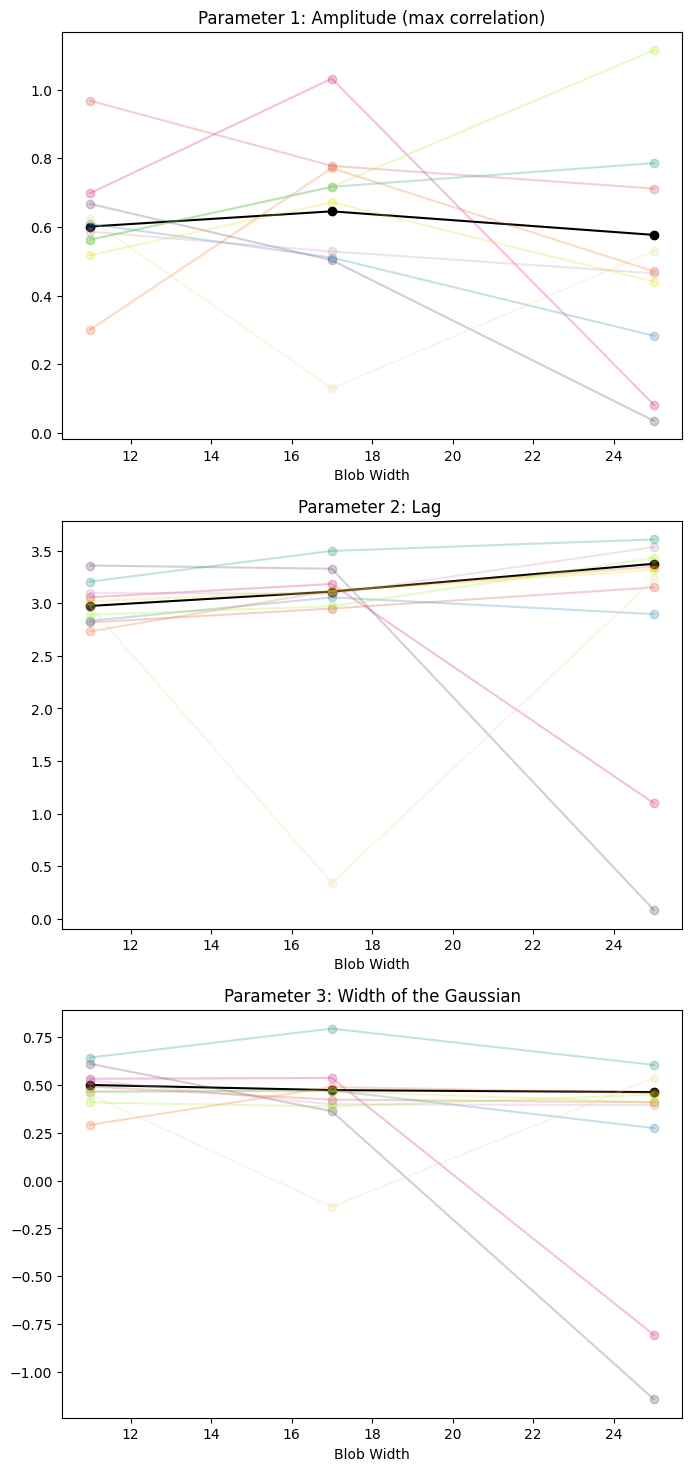

In [157]:
# file list in data_both
file_list = os.listdir("data_both")
from scipy.optimize import curve_fit
import math
frameRate=60
time_lag=1 # seconds
steps=int(frameRate*time_lag)
# Create the plot before the loop
#fig, ax = plt.subplots()
plt.figure(figsize=(20,10))
avgCCGBlobMeansAcrossParticipants = []
avgCCGSingleTrialsAcrossParticipants=[]
avgCCGSingleBlobsAcrossParticipants=[]
avgCCGSingleTrialsTrimmedAcrossParticipants=[]
avgCCGSingleBlobsTrimmedAcrossParticipants=[]


for fileN in range(len(file_list)-1):
    randomColorCode = np.random.rand(3,)
    fileIs,sigma, eyeResp, target, mouseResp = load_and_process_data("data_both", 'p'+str(fileN))[:5]
    trialDictSorted, tmp_trial = create_sorted_trial_dict(nTrial, target, eyeResp, sigma, fileIs, mouseResp)
    ccg_blob_mean_trimmed, ccg_single_trials_trimmed, ccg_blob_mean, ccg_single_blob,ccg_single_trials= process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range)
    # now combine all the ccgs for each of the participants and calculate the fit parameters
    avgCCGBlobMeansAcrossParticipants.append(ccg_blob_mean)
    avgCCGSingleTrialsAcrossParticipants.append(ccg_single_trials)
    avgCCGSingleBlobsAcrossParticipants.append(ccg_single_blob)
    avgCCGSingleTrialsTrimmedAcrossParticipants.append(ccg_single_trials_trimmed)
    avgCCGSingleBlobsTrimmedAcrossParticipants.append(ccg_blob_mean_trimmed)

    # plot the average CCG for each participant

    process_ccg_data(blob_widths, ccg_blob_mean, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots,alpha=0.25)


#plt.legend()
#plt.show()

# now plot the average CCG across all participants
avgCCGBlobMeansAcrossParticipants = np.array(avgCCGBlobMeansAcrossParticipants)
avgCCGSingleTrialsAcrossParticipants = np.array(avgCCGSingleTrialsAcrossParticipants)
avgCCGSingleBlobsAcrossParticipants = np.array(avgCCGSingleBlobsAcrossParticipants)
avgCCGSingleTrialsTrimmedAcrossParticipants = np.array(avgCCGSingleTrialsTrimmedAcrossParticipants)
avgCCGSingleBlobsTrimmedAcrossParticipants = np.array(avgCCGSingleBlobsTrimmedAcrossParticipants)

avgCCGBlobMeansAcrossParticipants = np.mean(avgCCGBlobMeansAcrossParticipants, axis=0)
avgCCGSingleTrialsAcrossParticipants = np.mean(avgCCGSingleTrialsAcrossParticipants, axis=0)
avgCCGSingleBlobsAcrossParticipants = np.mean(avgCCGSingleBlobsAcrossParticipants, axis=0)
avgCCGSingleTrialsTrimmedAcrossParticipants = np.mean(avgCCGSingleTrialsTrimmedAcrossParticipants, axis=0)
avgCCGSingleBlobsTrimmedAcrossParticipants = np.mean(avgCCGSingleBlobsTrimmedAcrossParticipants, axis=0)

alpha=1
process_ccg_data(blob_widths, avgCCGBlobMeansAcrossParticipants, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots,alpha=1,lw=5)
# add custom labels

plt.legend(['11','17','25'])
plt.show()

# plot subplots as well for the average CCG across all participants parameters
fig, axs = plt.subplots(3, 1)
fig.tight_layout(pad=30.0)
# size of subplots
fig.set_size_inches(8, 18)
plot_subplots(blob_widths, avgCCGBlobMeansAcrossParticipants, axs,alpha=1,color='black')

# plot the average CCG subplot parameters for each participant

GaussianFitParams = []


for fileN in range(len(file_list)-1):
    randomColorCode = np.random.rand(3,)
    fileIs,sigma, eyeResp, target, mouseResp = load_and_process_data("data_both", 'p'+str(fileN))[:5]
    trialDictSorted, tmp_trial = create_sorted_trial_dict(nTrial, target, eyeResp, sigma, fileIs, mouseResp)
    ccg_blob_mean_trimmed, ccg_single_trials_trimmed, ccg_blob_mean, ccg_single_blob,ccg_single_trials= process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range)
    popt_list,popt_covs=process_ccg_data(blob_widths, ccg_blob_mean, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots, alpha=1,lw=2, shouldPlot=False)
    GaussianFitParams.append(popt_list)
    plot_subplots(blob_widths, ccg_blob_mean, axs,alpha=0.25,color=randomColorCode)



## - Save fitting parameters

In [129]:
import os
os.listdir()

['.git',
 'conditions.ipynb',
 'conditions.npy',
 'create_conditions.py',
 'dva_to_pix.py',
 'recorded',
 'cont_psych_simpler_.py',
 '__pycache__',
 'lam.py',
 '1_data.csv',
 'data',
 'analysis_primier.ipynb',
 'analysis_m.m',
 'README.md',
 'analysis_26092023.ipynb',
 'tracking2graphs.m',
 'negLogLikelihoodr.m',
 'data.mat',
 'example.fig',
 'omer_pilot_2.mat',
 'audio_cue.py',
 'panning_beep_beep_beep.wav',
 'beep_beep_beep.wav',
 'right.wav',
 'left.wav',
 'audio_player_psychopy.py',
 'builder_coder',
 'example_trial.mp4',
 'audio_visual_target_tracking.py',
 'continous_psychophysics_moseTrackerDumb.py',
 '.vscode',
 'simple_tracker_experiment_0.py',
 'pyimagesearch',
 'simple_tracker_experiment_openCv.py',
 'Non included tuts',
 'eye_tracking_1.py',
 'Eye_tracking_continuous_psych.py',
 'et_data.EDF',
 'NoiseGenerator.py',
 'lqg straub analysis adaptation.ipynb',
 'data_eye',
 'data_both',
 'analysis_eye_mouse.ipynb',
 'kalman uncertainty estimates.ipynb',
 'Eye_tracking_continuous

In [105]:
# import pandas as pd
# df=pd.read_csv('df_final.csv')

In [65]:
# # summary df_all
# from plotly import __version__
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
# import plotly.offline as pyo
# import plotly.graph_objs as go
# from plotly.offline import iplot
# from scipy import stats
# import math

In [131]:
GaussianFitParams = np.array(GaussianFitParams)
amplitude = GaussianFitParams[:,:,0]
lag = GaussianFitParams[:,:,1]
width = GaussianFitParams[:,:,2]
import pandas as pd

df = pd.DataFrame(data=amplitude, columns=blob_widths)

# Reshape the DataFrame from wide format to long format
df_amplitude = df.melt(value_vars=blob_widths, var_name='blob_widths', value_name='amplitude')
df_amplitude

# Create and reshape the 'lag' DataFrame

df_lag = pd.DataFrame(data=lag, columns=blob_widths)
df_lag_melted = df_lag.melt(value_vars=blob_widths, var_name='blob_widths', value_name='lag')

# Create and reshape the 'width' DataFrame
df_width = pd.DataFrame(data=width, columns=blob_widths)
df_width_melted = df_width.melt(value_vars=blob_widths, var_name='blob_widths', value_name='width')

# Concatenate the 'amplitude', 'lag', and 'width' DataFrames
df_final = pd.concat([df_amplitude, df_lag_melted['lag'], df_width_melted['width']], axis=1)
df_final

df_final['participant'] = np.tile(np.arange(0,10,1),3)

df_final['respMode'] = np.repeat("eyeOnly",30)
df_eyeOnly=df_final.copy()
df_eyeOnly
#df_eyeWoouse
#df_mouse





,blob_widths,amplitude,lag,width,participant,respMode
0,11,0.049222,16.358917,7.644355,0,eyeOnly
1,11,0.027535,19.310716,8.596621,1,eyeOnly
2,11,0.015385,26.900807,16.796689,2,eyeOnly
3,11,0.031532,16.199317,6.910432,3,eyeOnly
4,11,0.033016,18.246781,6.653901,4,eyeOnly
5,11,0.028213,14.708586,3.823938,5,eyeOnly
6,11,0.023079,20.554183,8.698616,6,eyeOnly
7,11,0.025385,18.429260,6.734379,7,eyeOnly
8,11,0.012476,23.318629,20.703581,8,eyeOnly
9,11,0.032343,16.975986,6.709285,9,eyeOnly


In [132]:
# combine df_mouse and df_final
df = pd.concat([df_mouse, df_eyeOnly,df_eyeWoouse], axis=0)

# save df_final
#df_final.to_csv('df_final.csv',index=False)
# df_final.to_csv('df_final.csv',index=False)
# # Do anova test
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# from statsmodels.stats.anova import anova_lm

# # Fit the model
# model = ols('amplitude ~ C(blob_widths) + C(participant)+C(respMode)', data=df_final).fit()

# # Perform ANOVA
# anova_table = anova_lm(model, typ=2)
# print(anova_table)


In [133]:
df.describe()
df["participant"]= df["participant"].astype("category")
df["blob_widths"]=df["blob_widths"].astype("category")
df.to_csv('df_final.csv',index=False)

Text(0, 0.5, 'Mouse Response')

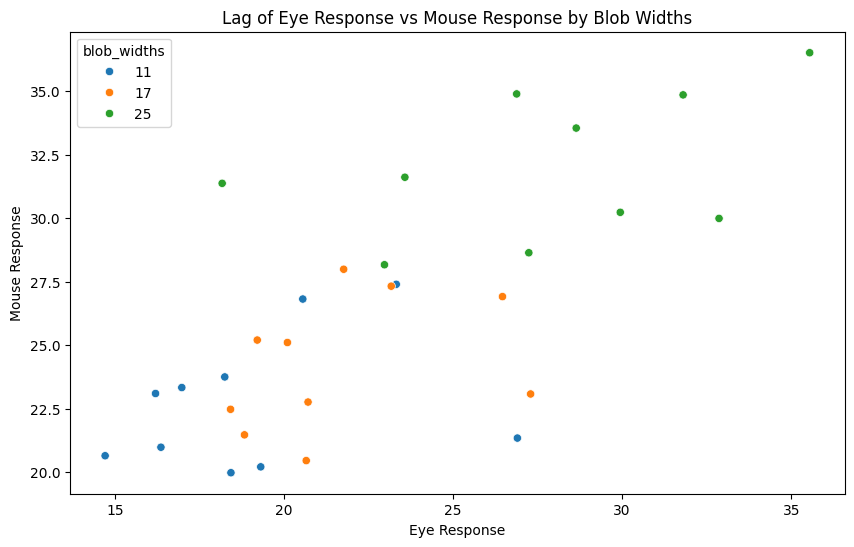

In [135]:

# Create separate dataframes for 'eyeResp' and 'mouseResp'
eye_df = df[df['respMode']=='eyeOnly'].rename(columns={'lag': 'lag_eye'})
mouse_df = df[df['respMode']=='mouse'].rename(columns={'lag': 'lag_mouse'})

# Merge the dataframes on 'participant' and 'blob_widths'
merged_df = pd.merge(eye_df, mouse_df, on=['participant', 'blob_widths'])

# Plot the data
plt.figure(figsize=(10,6))
sns.scatterplot(x='lag_eye', y='lag_mouse', data=merged_df, hue='blob_widths')
plt.title('Lag of Eye Response vs Mouse Response by Blob Widths')
plt.xlabel('Eye Response')
plt.ylabel('Mouse Response')

Text(0, 0.5, 'Mouse Response')

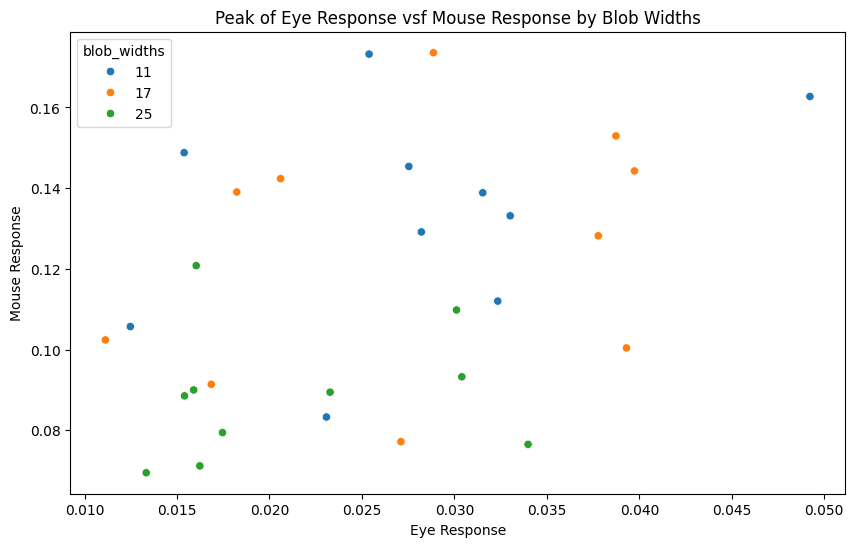

In [87]:

# Create separate dataframes for 'eyeResp' and 'mouseResp'
eye_df = df[df['respMode']=='eye'].rename(columns={'amplitude': 'peak_eye'})
mouse_df = df[df['respMode']=='mouse'].rename(columns={'amplitude': 'peak_mouse'})

# Merge the dataframes on 'participant' and 'blob_widths'
merged_df = pd.merge(eye_df, mouse_df, on=['participant', 'blob_widths'])

# Plot the data
plt.figure(figsize=(10,6))
sns.scatterplot(x='peak_eye', y='peak_mouse', data=merged_df, hue='blob_widths')
plt.title('Peak of Eye Response vsf Mouse Response by Blob Widths')
plt.xlabel('Eye Response')
plt.ylabel('Mouse Response')